<a href="https://colab.research.google.com/github/prashants975/Projects_on_ML/blob/master/InstaCart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prashants975","key":"dd24bf62a12c96d43ef7ffbee0f517f8"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s instacart-market-basket-analysis

ref                                       title                              size  lastUpdated          downloadCount  
----------------------------------------  --------------------------------  -----  -------------------  -------------  
psparks/instacart-market-basket-analysis  Instacart Market Basket Analysis  197MB  2017-11-20 03:08:26           1907  
samwhitehill/instacart-training-sample    InstaCart training sample           1MB  2017-07-01 20:24:11             65  


In [6]:
!kaggle datasets download -d psparks/instacart-market-basket-analysis

 97% 191M/197M [00:03<00:00, 99.6MB/s]
100% 197M/197M [00:03<00:00, 66.2MB/s]


In [7]:
!unzip /content/instacart-market-basket-analysis

Archive:  /content/instacart-market-basket-analysis.zip
  inflating: order_products__train.csv  
  inflating: products.csv            
  inflating: orders.csv              
  inflating: order_products__prior.csv  
  inflating: aisles.csv              
  inflating: departments.csv         


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

## Loading the Data

In [9]:
order_products_train = pd.read_csv('/content/order_products__train.csv')
print(order_products_train.shape)
order_products_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
products = pd.read_csv('/content/products.csv')
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
orders = pd.read_csv('/content/orders.csv')
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
order_products__prior = pd.read_csv('/content/order_products__prior.csv')
print(order_products__prior.shape)
order_products__prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
aisles = pd.read_csv('/content/aisles.csv')
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [14]:
departments = pd.read_csv('/content/departments.csv')
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Visulaization
Lets try to find important features and relations for predicting reordering of a specific item by a users.

In [15]:
orders_test = orders[orders['eval_set'] == 'test']
print(orders_test.shape)
orders_test.head()

(75000, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [16]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

Lets see the trends in **order_numbers, order_dow, order_hour_of_day and days_since_prior_order**.<br>
We can take whole order dataframe for plotting without worrying about biases in the model for train and test as it is very small compare to the whole dataset.



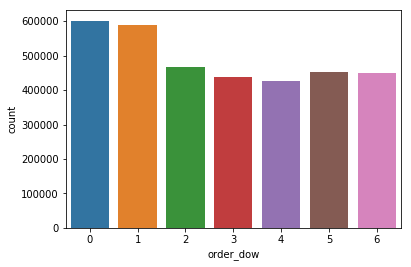

In [17]:
sns.countplot(x="order_dow", data = orders);

Number of orders reamins almost similar throughout the week except on 0 and 1 which can be the weekends representation and the day the highest amount order comes on the website.

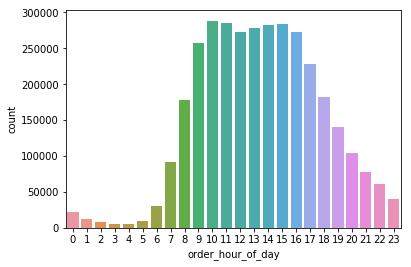

In [18]:
sns.countplot(x="order_hour_of_day", data = orders);

Most of orders frequencies are in between 8th to 19th hour.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

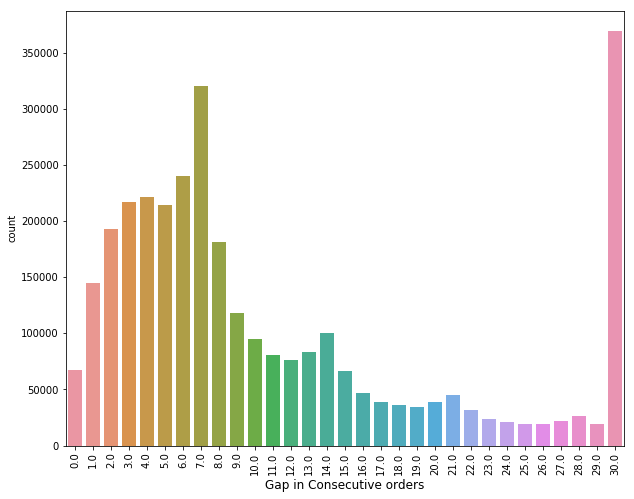

In [19]:
plt.figure(figsize=(10,8))
sns.countplot(x="days_since_prior_order", data = orders);
plt.xlabel('Gap in Consecutive orders', fontsize=12)
plt.xticks(rotation='vertical')

There is a peak at 7 day and 30 days which suggest the highest frequency for gap in consecutive orders is a week or a month. Which also shows that the users are usually order on weakly and monthly basis. 

In [20]:
order_products_train['product_id'].value_counts().head(10)

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
Name: product_id, dtype: int64

In [21]:
train_full = pd.merge(order_products_train, orders,how = 'inner', on = 'order_id')
train_full = pd.merge(train_full,products ,how = 'inner', on = 'product_id')
train_full.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16


In [22]:
reorder_ratio_by_add_to_cart_order = train_full.groupby('add_to_cart_order')['reordered'].aggregate("mean").reset_index()
reorder_ratio_by_add_to_cart_order.head()


,add_to_cart_order,reordered
0,1,0.722641
1,2,0.698884
2,3,0.667972
3,4,0.646935
4,5,0.622800


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 80 Text xticklabel objects>)

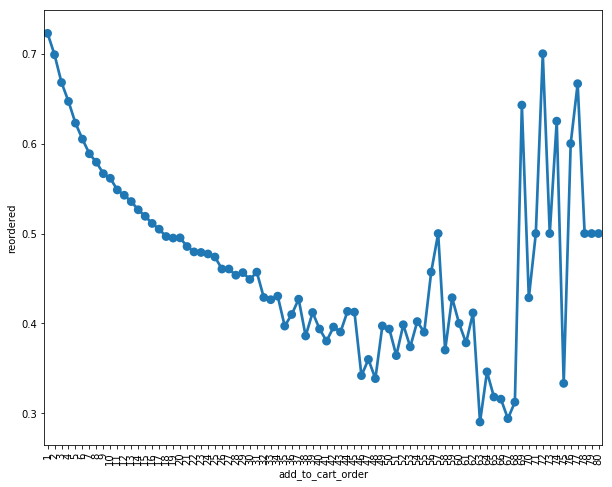

In [23]:
plt.figure(figsize = (10,8))
sns.pointplot(reorder_ratio_by_add_to_cart_order['add_to_cart_order'],reorder_ratio_by_add_to_cart_order['reordered'] );
plt.xticks(rotation='vertical')

The items that are added first in the cart have higher probability of reordering, so that looks like a good intuitive feature for our training set.<br>

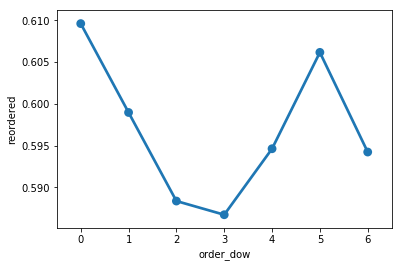

In [24]:
dow_by_reordered_ratio = train_full.groupby('order_dow')['reordered'].aggregate("mean").reset_index()
dow_by_reordered_ratio.head()
sns.pointplot(dow_by_reordered_ratio['order_dow'], dow_by_reordered_ratio['reordered'])

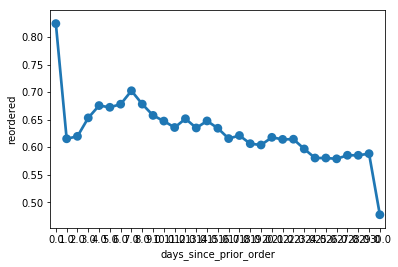

In [25]:
gap_by_reordered_ratio = train_full.groupby('days_since_prior_order')['reordered'].aggregate("mean").reset_index()
gap_by_reordered_ratio.head()
sns.pointplot(gap_by_reordered_ratio['days_since_prior_order'], gap_by_reordered_ratio['reordered'])

Products which are ordered in a gap of 2-3 days or after 7 days are high probabilty of being reordered after that the general trend is in decrease of reordering.

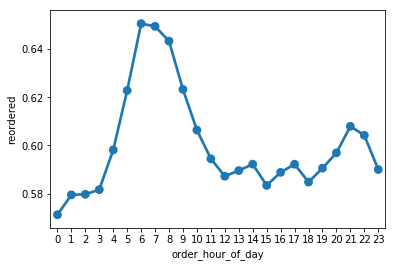

In [26]:
order_hour_of_day_by_reordered_ratio = train_full.groupby('order_hour_of_day')['reordered'].aggregate("mean").reset_index()
order_hour_of_day_by_reordered_ratio.head()
sns.pointplot(order_hour_of_day_by_reordered_ratio['order_hour_of_day'], order_hour_of_day_by_reordered_ratio['reordered'])

There is hardly any difference when ordering at any hour, even though graph peaks ar 6 hour but the difference in the reordering is very small

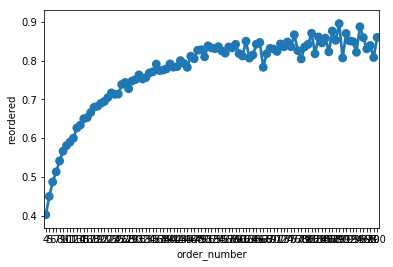

In [27]:
order_number_by_reordered_ratio = train_full.groupby('order_number')['reordered'].aggregate("mean").reset_index()
order_number_by_reordered_ratio.head()
sns.pointplot(order_number_by_reordered_ratio['order_number'], order_number_by_reordered_ratio['reordered'])

The genral trend is that if an order number is very high for the user then it is very likeyly he will be reording some of the previous items which may suggest loyality.

In [0]:
col = ['product_id','add_to_cart_order', 'user_id', 'order_number', 'days_since_prior_order' ]
X = train_full[col]
Y = train_full['reordered']



In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify =  Y)

In [0]:
feature_columns = []
for feature_name in col:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.int32))

In [0]:
#directly using input_function of tf.org
n = len(Y)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(n)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    # In memory training doesn't use batching.
    dataset = dataset.batch(n)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)

In [32]:
est = tf.estimator.BoostedTreesClassifier(feature_columns,n_batches_per_layer=1)

W0702 14:31:55.865750 140589692761984 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpxhw_xh8y


In [33]:
est.train(train_input_fn, max_steps=100)


W0702 14:31:55.928551 140589692761984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0702 14:31:56.068104 140589692761984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0702 14:31:56.257553 140589692761984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/canned/h

KeyboardInterrupt: ignored

In [0]:
results = est.evaluate(eval_input_fn)